In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src.backward import KNNCalibrator
import numpy.random as rng
from resources.OTHERS.models import paraboloid_model
from src.plot import scatter_post
from src.plot import plot_kde_2d

Generate empirical evidence (data from an unknown data gen process)

* Case 1 - 1 sample (y), 1 target (θ point-valued), 1 experiment (ξ)
* Case 2 - 100 sample (y) from 100 targets (θ distribution), 1 experiment (ξ)
* Case 3 - 100 sample (y) from 100 targets (θ distribution), for 5 experiments (ξ)


In [3]:
def sample_true_uncertainty_model_2d(N=10, rng=np.random.default_rng()):
    xa = rng.normal(4.0, 0.5, size=(N, 2))   # aleatoric
    xe = np.tile([2.0, 0.0], (N, 1))         # epistemic (fixed, repeated)
    return np.hstack([xa, xe])

# generate data for the horse and pony show
N_emp = 200
theta_true_cloud = sample_true_uncertainty_model_2d(200)
xi_list_c3 = [-2.0, -1.0, 2.0, 4.0]
observations_c3 = []
for xi in xi_list_c3:
    y_emp  = paraboloid_model(theta_true_cloud, xi)  # shape (100,1) per design
    observations_c3.append((y_emp, xi))

print(f"CASE 3 - designs: {len(observations_c3)} samples: {observations_c3[0][0].shape[0]}")



CASE 3 - designs: 4 samples: 200


Reuse precomputed simulations (evaluate_model=False)

Build one big (θ, ξ) pool, then filter by ξ* to create per-design kNN indices


In [7]:
N_SIM, knn, resample_n = 2_250_000, 50, 5_000

def xa_sampler(n, lb=-15, ub=15):
    return np.random.uniform(lb, ub, size=(n, 2))

xe_sim_pool  = np.tile([2.5, 20.0], (N_SIM, 1))  # at the moment we fix this for the paraboloid model
xa_sim_pool = xa_sampler(N_SIM)
theta_sim_pool = np.hstack([xa_sim_pool, xe_sim_pool])
xi_sim_pool = rng.uniform(-5, 5, size=(N_SIM, 1))
y_sim_pool = paraboloid_model(theta_sim_pool, xi_sim_pool)
simulated_data = {"y": y_sim_pool, "theta": theta_sim_pool, "xi": xi_sim_pool}



In [ ]:
calib_comb = KNNCalibrator(knn=knn, evaluate_model=False, a_tol=0.05) # 'prep calibrator model
calib_comb.setup(simulated_data=simulated_data, xi_list=xi_list_c3)

# 'vote' = stack
posterior_knn = calib_comb.calibrate(observations_c3, combine="stack", resample_n=resample_n)
theta_post_stack = posterior_knn["theta"]
# 'vote' = intersect
posterior_knn = calib_comb.calibrate(observations_c3, combine="intersect", resample_n=resample_n)
theta_post_intersect= posterior_knn["theta"]

fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post_stack, truth=theta_true_cloud, title="Unified kNN — reusing in-out simulations (and stack method)")
plot_kde_2d(theta_post_stack[:,:2], true_theta=theta_true_cloud, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post_intersect, truth=theta_true_cloud,  title="Unified kNN — evaluate per design (combine='intersect')")
plot_kde_2d(theta_post_intersect[:,:2], true_theta=theta_true_cloud, ax=ax)
plt.show()

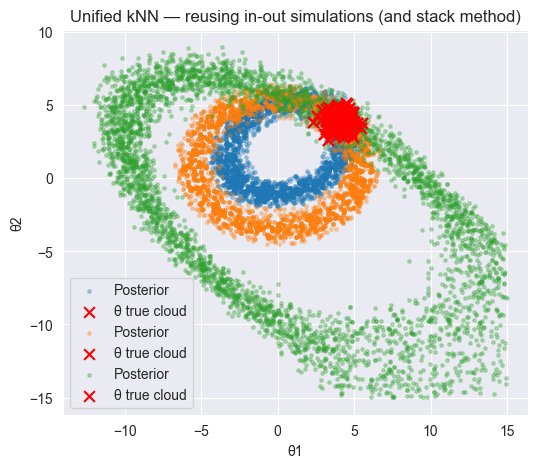

In [8]:
from src.backward import estimate_p_theta_knn

fig, ax = plt.subplots(figsize=(6,5))

simulated_data = [y_sim_pool, theta_sim_pool, xi_sim_pool]
observed_data, xi_star = observations_c3[0]
theta_cal_knn = estimate_p_theta_knn(observed_data,  simulated_data,  xi_star)
scatter_post(ax, theta_cal_knn[:,:2], truth=theta_true_cloud, title="Unified kNN — reusing in-out simulations (and stack method)")

observed_data, xi_star = observations_c3[1]
theta_cal_knn = estimate_p_theta_knn(observed_data,  simulated_data,  xi_star)
scatter_post(ax, theta_cal_knn[:,:2], truth=theta_true_cloud, title="Unified kNN — reusing in-out simulations (and stack method)")

observed_data, xi_star = observations_c3[2]
theta_cal_knn = estimate_p_theta_knn(observed_data,  simulated_data,  xi_star, a_tol=0.5)
scatter_post(ax, theta_cal_knn[:,:2], truth=theta_true_cloud, title="Unified kNN — reusing in-out simulations (and stack method)")

plt.show()

NameError: name 'calib_comb' is not defined

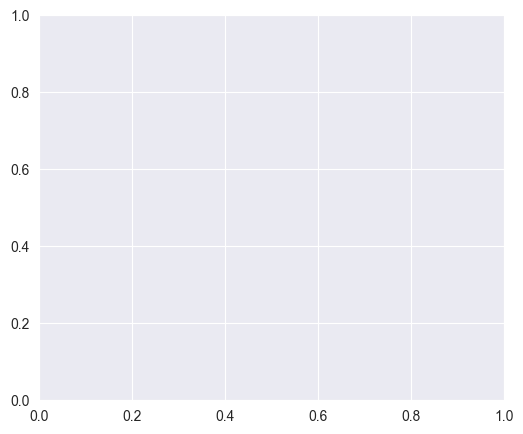

In [6]:
fig, ax = plt.subplots(figsize=(6,5))
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for c, xi in zip(colors, xi_list_c3):
    post_xi = calib_comb.calibrate([(next(y for (y,x) in observations_c3 if np.isclose(x, xi)), xi)],  combine="stack", resample_n=5000)
    th_xi = post_xi["theta"]
    ax.scatter(th_xi[:,0], th_xi[:,1], s=4, alpha=0.25, label=f"ξ={xi}", c=c)
ax.scatter(theta_true_cloud[:,0], theta_true_cloud[:,1], c="k", marker="x", s=40, label="θ true cloud")
ax.set_title("Per-design posteriors (overlaid) — unified kNN")
ax.set_xlabel("θ1"); ax.set_ylabel("θ2"); ax.grid(True); ax.legend()
plt.show()

In [ ]:
from scipy.stats import gaussian_kde
posters = []
for xi in xi_list_c3:
    y_i = next(y for (y,x) in observations_c3 if np.isclose(x, xi))
    post_i = calib_comb.calibrate([(y_i, xi)], combine="stack", resample_n=1000)
    posters.append((xi, post_i["theta"]))

stack_all = np.vstack([th for _, th in posters] + [theta_true_cloud])
x_min, x_max = np.percentile(stack_all[:,0], [1, 99])
y_min, y_max = np.percentile(stack_all[:,1], [1, 99])
nx, ny = 200, 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
grid = np.vstack([xx.ravel(), yy.ravel()])

zz = np.zeros((ny, nx))
for (c, (xi, th_xi)) in zip(colors, posters):
    kde = gaussian_kde(th_xi.T, bw_method='scott') # KDE on the posterior samples of this design
    zz_grid = kde(grid).reshape(ny, nx)
    zz += np.log(zz_grid)

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
zz_lik = np.exp(zz)# filled contours + a thin outline
ax.scatter(theta_true_cloud[:,0], theta_true_cloud[:,1], c="r", marker="x", s=30, label="θ true cloud")  # true cloud on top
csf = ax.contourf(xx, yy, zz_lik, levels=8, alpha=0.3, antialiased=True)
ax.contour(xx, yy, zz_lik, levels=8, colors='b', linewidths=0.9)
ax.set_title("Per-design posterior densities (KDE) — unified kNN")
ax.set_xlabel("θ1"); ax.set_ylabel("θ2"); ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
ax.grid(True); ax.legend()
plt.show()